# Importación de librerías

Librerías de Python necesarias para la ejecución del código

In [1]:
import sys; sys.path.insert(0, '../..')
import sys; sys.path.insert(0, '../../src/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
import utils.factory as factory
from utils.config import Config

from sklearn.neighbors import NearestCentroid

# mc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
import scipy.ndimage as ndimage


from glob import glob
import os
import io
import imageio
import random
import math
import time
import shutil
import json
import cv2

%load_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Funciones de ejecución

Funciones que se utilizarán a lo largo del código

In [2]:
def get_metrics(y_true, y_pred, classes, cm_path=None):
    """Función para representar la matriz de confusión y obtener las 
       métricas por clase
       
       Args:
           y_true: [List]. Clases verdaders
           y_pred: [List]. Clases predichas
           classes: [List]. Listado de nombre de las clases
           cm_path: [String]. Si se aporta un path se guardará la img de la
                              matriz de confusión ahí.
           
       Returns:
           metrics: [Dict]. Clave el nombre de la clase, valor el listado con
                            las métricas por clase [recall, precision, f1, accuracy]
    """
    # Imprimimos la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm, index = [n for n in classes],
                      columns = [n for n in classes])
    plt.figure(figsize = (16,12))
    sn.heatmap(df_cm, annot=True)
    
    if cm_path is not None:
        plt.savefig(cm_path)
        
    # Obtenemos valores de TP, FN, FP y TN y las metricas
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
    # Sensitivity, hit rate, recall, or true positive rate
    recall = TP/(TP+FN)
    # Specificity or true negative rate
    specificity = TN/(TN+FP) 
    # Precision or positive predictive value
    prec = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    acc = (TP+TN)/(TP+FP+FN+TN)
    # f1-scores
    f1 = 2*(prec * recall)/(prec + recall)
    
    # Obtenems las métricas por clase
    metrics = {}
    for i, _class in enumerate(classes):
        metrics[_class] = [recall[i], prec[i], f1[i], acc[i]]
    
    return metrics
    
def test_cnn(model, data, cm_path, normalize=False):
    """Función para realizar el test de un modelo de CNN dado el modelo y los datos.
    
    Args:
        model [Keras model]. Modelo entrenado sobre el que proboar las imgs.
        data [TF.Data]. Conjunto de datos cargado con la librería de TF.
        cm_path [String]. Path donde guardar la matriz de confusión
        normalize [Boolean]. Valor para saber si es preciso normalizar los datos de test.
        
    Returns:
        metrics. Métricas por clase del modelo testeado con el conjunto de test.
    
    """
    # Recorremos el conjunto de test y anotamos las predicciones y los Ground Truth
    y_true = []
    y_pred = []
    
    # Normalizamos si es necesario
    if normalize:
        data.test = data.test.map(normalize)
        data.test = data.test.map(_fixup_shape)

    # Recorremos el conjunto de test y sacamos las predicciones
    for i, (im, label) in enumerate(data.test):
            # pred
            pred = model.model.predict(tf.expand_dims(im, axis = 0))
            y_pred.append(np.argmax(pred[0]))
            # gt
            class_index = np.argmax(label.numpy())
            y_true.append(class_index)


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return get_metrics(y_true, y_pred, data.class_names, cm_path)

def test_fsl(model, feature_extractor_model, query_classes, query_files_path, cm_path, normalize=False):
    """Función para realizar un test completo del modelo de FSL
       
       Args:
           model: [NearestNeighbor]. Modelo de clasificación NearestNeighbor 
           feature_extractor_model: [Keras Model]. Modelo keras CNN para la extracción de caract.
           query_classes: [List]. Listado de clases sobre las que se realiza la prueba
           query_files_path: [List]. Listado de paths de imgs para la prueba
           cm_path [String]. Path donde guardar la matriz de confusión generada
           normalize [Boolean]. Valor para indicar si hay que normalizar o no el valor de entrada al
                                extractor de características
           
       Returns:
           metrics: [Dict]. Clave el nombre de la clase, valor el listado con
                            las métricas por clase [recall, precision, f1, accuracy]
    """
    # Recorremos el conjunto de test y anotamos las predicciones y los Ground Truth
    y_true = []
    y_pred = []

    # Recorremos las imágenes del conjunto Query (Q) y guardamos el vector para cada una de ellas
    dict_query_features = {}
    for i, _class in enumerate(query_classes):
        for j, image_path in enumerate(query_files_path[i]):
            if os.path.isfile(image_path):# para evitar errores con el directorio @eaDir de Synology
                # leemos la imagen
                if normalize:
                    img = plt.imread(image_path).astype('uint8') * (1./255.)
                else:
                    img = plt.imread(image_path).astype('uint8')
                img = tf.image.resize_with_pad(img, target_height=224, target_width=224)

                # para cada una de ellas obtenemos el vector de características
                feature_output = feature_extractor_model(tf.expand_dims(img, axis=0))
                #print(feature_output.numpy()[0])
                # lo incluimos en el listado de la clase
                if _class not in dict_query_features:
                    dict_query_features[_class] = feature_output.numpy()#[0]
                else:
                    dict_query_features[_class] = np.vstack(
                                                    (dict_query_features[_class],
                                                    feature_output.numpy()))#[0]))

    _classes = dict_query_features.keys()
    for i, _class in enumerate(dict_query_features):
        # recorremos los vectores de características de una clase para calcular su predicción
        class_embeddings = dict_query_features[_class]

        for embedding in class_embeddings:
            prediction_class = model.predict([embedding])[0]
            y_true.append(_class)
            y_pred.append(prediction_class)

                    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return get_metrics(y_true, y_pred, _classes, cm_path)

def train_model(config_file, config_file_FT):
    """Función que realiza el entrenamiento del modelo de CNN en 
    base las configuraciones definidas en el fichero pasado por parámetro
    
    Args:
        config_file [String]: Path del fichero de configuración donde se define
                              la configuración del entrenamiento del modelo.
        config_file_FT [String]: Path del fichero de configuración del modelo
                                 de referencia de FT.
    Returns:
        [float] Tiempo que ha durado el entrenamiento
        [tf.keras.Model] Modelo extractor de características
        [Config] Clase propia del proyecto en el que encaja el TFE 
                 con las configuraciones de entrenamiento cargadas
        [DataLoader] Clase propia del proyecto en el que encaja el TFE
                     para cargar los datos de test, train y validation
                     según la división indicada en el fichero de config.
        Ejemplo Carga de datos:
            raw_dataset = tf.data.Dataset.list_files(str(self.data_dir/'*/*'), shuffle=False)
            train_ds = self.raw_dataset.take(int(train_size))
            val_ds = self.raw_dataset.skip(train_size).take(val_size)
            test_ds = self.raw_dataset.skip(train_size + val_size).take(test_size)
        
        Ejemplo Carga del modelo CNN solo para reentrenar las capas fully-connected:

            from tensorflow.keras import layers
            # Congelamos los pesos de la capas convolucionales
            model.trainable = False

            # Rehacemos las capas fully connected
            outputs = layers.GlobalAveragePooling2D(name="avg_pool")(model.layers[-5].output)
            outputs = layers.BatchNormalization()(outputs)

            outputs = layers.Dropout(self.config.dropout,
                                    name="top_dropout")(outputs)
            outputs = layers.Dense(
                self.config.data_loader["n_classes"],
                activation="softmax",
                name="classes_prediction")(outputs)

            print("num_classes: {}".format(self.config.data_loader["n_classes"]))

            # Construimos el modelo con Keras Build
            model = tf.keras.Model(model.input, outputs, name="DenseNet121_Ships")

            # Compile model
            model.compile(loss=self.loss,
                        optimizer=self.optimizer,
                        metrics=['accuracy'])
    
    """
    # Cargamos el modelo preentrenado con FT
    config_ft = Config(config_file_FT)#"../../src/configs/seda_boat_classif_tfm_mnm_FT.json")
    model_ft = factory.Model(config_ft)
    model_ft.load(config_ft.callbacks['checkpoint_dir'])

    # Cargamos configuración para el entrenamiento del clasificador x-shot_y-novel_z-extra
    config = Config(config_file)
    # cargamos los datos de entrenamiento
    data = factory.DataLoader(config)
    
    # modificamos el número de elementos de train
    ###config_ft.trainer['train_set'] = 150#len(data.train)
    # modificamos el número de elementos de val
    ###config_ft.trainer['val_set'] = len(data.val)
    # modificamos el número de clases del entrenamiento
    config_ft.data_loader['num_classes'] = len(data.class_names)
    config_ft.data_loader['n_classes'] = len(data.class_names)
    
    # Aplicamos data augmentation (albumentation)
    transformer = factory.Transformer(config) #
    data.train = transformer.transform(data.train)
    
    # Preparamos el modelo, esta llamada congelará las capas convolucionales y añadirá capas
    # de fully connected con tantas clases de salida como se requeiran.
    model = factory.Model_TFM_MNM(config, model_ft.model)
    #model.load(config_ft.callbacks['checkpoint_dir'])
  

    # Borramos los resultados del anterior experimento
    path_checkpoints = os.path.join('experiments','checkpoints',config.exp['name'], config.model['tag'])
    if os.path.exists(path_checkpoints): shutil.rmtree(path_checkpoints)

    # Preparamos el callback para reducir el LR cada 25 epochs
    custom_callbacks = [tf.keras.callbacks.LearningRateScheduler(step_decay)]

    trainer = factory.Trainer(model.model, data.train, data.val, config,
                            custom_callbacks=custom_callbacks)

    # Entrenamos el modelo
    time_new_1s_1n_start = time.time()
    trainer.train()
    time_new_1s_1n_end = time.time()
    trainning_duration = time_new_1s_1n_end-time_new_1s_1n_start

    print("El entrenamiento con 50 epochs ha durado: {} s".format(trainning_duration))

    return trainning_duration, model, config, data

def train_model_fsl(model_ft, support_classes, support_files_path, normalize=False):
    """Función que realiza el entrenamiento del modelo de FSL en 
    base a las imágenes alojadas en el path que se pasa por parámetro.
    
    Args:
        model_ft [TF Model]: Modelo preentrenado con clases de buques base
        support_classes [List[String]]: Listado de clases nuevas para entrenar 
                                        modelo de FSL.
        support_files_path [List[list[String]]: Listado de lista de imgs de soporte para entrenar
                                          el modelo de FSL.
                                          [["/path/img/class1/1.png", "/path/img/class1/2.png"],
                                           ["/path/img/class2/1.png", "/path/img/class2/2.png"]]
    Returns:
        [float] Tiempo que ha durado el entrenamiento
        [NearestCentroid] Clasificador FSL
        [tf.keras.Model] Modelo extractor de características
        [Dictionary] Diccionario traductor de índice a clase       
    
    """
    model = model_ft.model

    # Nos quedamos solamente con las capas CNN
    layer_name = 'avg_pool'
    feature_extractor_model = tf.keras.Model(inputs=model.input,
                                             outputs=model.get_layer(layer_name).output)

    # Recorremos las imágenes del conjunto Support (S) y guardamos el vector para cada una de ellas
    dict_support_features = {}
    trainning_start_time = time.time()
    for i, _class in enumerate(support_classes):
        for j, image_path in enumerate(support_files_path[i]):
            # leemos la imagen
            if normalize:
                img = plt.imread(image_path).astype('uint8')  * (1./255.)
            else:
                img = plt.imread(image_path).astype('uint8')
            img = tf.image.resize_with_pad(img, target_height=224, target_width=224)

            # para cada una de ellas obtenemos el vector de características
            feature_output = feature_extractor_model(tf.expand_dims(img, axis=0))
            #print(feature_output.numpy()[0])
            # lo incluimos en el listado de la clase
            if _class not in dict_support_features:
                dict_support_features[_class] = feature_output.numpy()#[0]
            else:
                dict_support_features[_class] = np.vstack(
                                                (dict_support_features[_class],
                                                feature_output.numpy()))#[0]))

    # Array que contendrá los puntos centrales obtenidos mediante Nearest Neighbor
    prototype_representation = np.array([])

    # Preparamos los datos para generar el clasificador de Nearest Neighbors
    X = np.array([])
    Y = np.array([])
    index_to_class = {}
    for i, _class in enumerate(dict_support_features):
        if X.shape[0] == 0:
            # primera iteración
            X = dict_support_features[_class]
        else:
            # en el resto concatenamos los resultados
            X = np.concatenate((X, dict_support_features[_class]))
        Y = np.concatenate((Y, np.array([_class]*dict_support_features[_class].shape[0])))

        # Construimos diccionario traductor de index a clase
        index_to_class[i] = _class

    # Obtenemos Prototype representation con los vectores de características de cada clase
    clf = NearestCentroid(metric='euclidean')
    clf.fit(X, Y)

    trainning_end_time = time.time()

    trainning_duration = trainning_end_time - trainning_start_time
    return trainning_duration, clf, feature_extractor_model, index_to_class

def prepare_data(num_train_imgs, num_novel_classes, num_extra_classes):
    """Función para preparar los datos para el entrenamietno del modelo de CNN.
       Repartirá 1 o 5 imágenes, según se indique en "num_train_imgs" y elegirá
       además de las clases base, 1-5 o 1-2 de las clases novel y extra respectivamente
       según lo indicado en "num_novel_classes", "num_extra_classes"
       
       Args:
           num_train_imgs [Int]. Número de imágenes de referencia que poner en train
           num_novel_classes [Int]. Número de clases del grupo novel a elegir para el entrenamiento
           num_extra_classes [Int]. Número de clases del grupo extra a elegir para el entrenamiento
           
       Returns:
           metric_classes [List]. Listado de clases utilizadas para el entrenamiento
    
    """
    trainning_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/training_tests"
    fsl_base_classes_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base/FSL/allImages"
    fsl_new_classes_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/novel/FSL/allImages"
    fsl_extra_classes_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/extra/FSL/allImages"

    paths_fsl = [fsl_base_classes_path, fsl_new_classes_path, fsl_extra_classes_path]


    # limpio el path de entrenamiento
    if os.path.exists(trainning_path): shutil.rmtree(trainning_path)
    #print("BORRADO: {}".format(test_path))
    if not os.path.exists(trainning_path): os.makedirs(trainning_path)

    metric_classes = []
    
    
    for path in paths_fsl:
        # Seteamos la semilla de random según la marca de tiemo, para que en cada pasada sea diferente la eleccion
        random.seed(int(time.time()))

        # Obtener el numero de clases aleatorias
        classes = os.listdir(path)

        if "novel" in path:
            random.shuffle(classes)
            classes =  classes[0:num_novel_classes]
        elif "extra" in path:
            random.shuffle(classes)
            classes =  classes[0:num_extra_classes]


        metric_classes.append(classes)
        #para cada clase muevo 'num_train_imgs' al path 'train' y del resto dividio un 50% validación y 50% para test
        for _class in classes:
            # creamos los paths de train, val y test para el entrenamiento CNN
            dst_path_train = os.path.join(trainning_path, 'train', _class)
            if not os.path.exists(dst_path_train): os.makedirs(dst_path_train)
            dst_path_val = os.path.join(trainning_path, 'val', _class)
            if not os.path.exists(dst_path_val): os.makedirs(dst_path_val)
            dst_path_test = os.path.join(trainning_path, 'test', _class)
            if not os.path.exists(dst_path_test): os.makedirs(dst_path_test)

            # Selecciono
            #print("\tCopio los ficheros para {}".format(_class))
            imgs_class_path = os.path.join(path, _class)
            files = os.listdir(imgs_class_path)
            random.shuffle(files)
            ### TRAIN IMGS
            select_imgs =  files[0:num_train_imgs]
            del files[:num_train_imgs]
            #print("Imagenes elegidas para 'train': {}".format(select_imgs))
            for img in select_imgs:
                #print("\t\t\t[train] COPIADO {} a {}".format(os.path.join(imgs_class_path, img), os.path.join(dst_path_train, img)))
                shutil.copyfile(os.path.join(imgs_class_path, img), os.path.join(dst_path_train, img))

            ### VAL IMGS
            num_val_imgs = int(len(files)*0.5)
            select_imgs =  files[0:num_val_imgs]
            del files[:num_val_imgs]
            #print("Imagenes elegidas de {} para 'val': {}".format(_class, len(select_imgs)))
            for img in select_imgs:
                #print("\t\t\t[val] COPIADO {} a {}".format(os.path.join(imgs_class_path, img), os.path.join(dst_path_val, img)))
                shutil.copyfile(os.path.join(imgs_class_path, img), os.path.join(dst_path_val, img))

            ### TEST IMGS
            #print("Imagenes elegidas de {} para 'test': {}".format(_class, len(files)))
            for img in files:
                #print("\t\t\t[test] COPIADO {} a {}".format(os.path.join(imgs_class_path, img), os.path.join(dst_path_test, img)))
                shutil.copyfile(os.path.join(imgs_class_path, img), os.path.join(dst_path_test, img))
    

    return metric_classes

def prepare_data_to_fsl(num_train_imgs, num_novel_classes, num_extra_classes):
    """Función para preparar los datos para el entrenamietno del modelo de FSL.
       Repartirá 1 o 5 imágenes, según se indique en "num_train_imgs" y elegirá
       además de las clases base, 1-5 o 1-2 de las clases novel y extra respectivamente
       según lo indicado en "num_novel_classes", "num_extra_classes"
       
       Args:
           num_train_imgs [Int]. Número de imágenes de referencia que poner en train
           num_novel_classes [Int]. Número de clases del grupo novel a elegir para el entrenamiento
           num_extra_classes [Int]. Número de clases del grupo extra a elegir para el entrenamiento
           
       Returns:
           metric_classes [List]. Listado de clases utilizadas para el entrenamiento
    
    """
    trainning_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/training_tests"
    fsl_base_classes_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base/FSL/allImages"
    fsl_new_classes_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/novel/FSL/allImages"
    fsl_extra_classes_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/extra/FSL/allImages"

    paths_fsl = [fsl_base_classes_path, fsl_new_classes_path, fsl_extra_classes_path]

    # limpio el path de entrenamiento
    if os.path.exists(trainning_path): shutil.rmtree(trainning_path)
    #print("BORRADO: {}".format(test_path))
    if not os.path.exists(trainning_path): os.makedirs(trainning_path)

    metric_classes = []

    for path in paths_fsl:
        #print("Path origen: {}".format(path))
        random.seed(int(time.time()))

        classes = os.listdir(path)

        if "novel" in path:
            random.shuffle(classes)
            ### TRAIN IMGS
            classes =  classes[0:num_novel_classes]
        elif "extra" in path:
            random.shuffle(classes)
            ### TRAIN IMGS
            classes =  classes[0:num_extra_classes]


        metric_classes.append(classes)
        #para cada clase muevo 'num_train_imgs' al path 'train' y el resto para test
        for _class in classes:
            #print("\tGenero paths para {}".format(_class))
            dst_path_support = os.path.join(trainning_path, 'S', _class)
            if not os.path.exists(dst_path_support): os.makedirs(dst_path_support)
            dst_path_query = os.path.join(trainning_path, 'Q', _class)
            if not os.path.exists(dst_path_query): os.makedirs(dst_path_query)

            #print("\tCopio los ficheros para {}".format(_class))
            imgs_class_path = os.path.join(path, _class)
            files = os.listdir(imgs_class_path)
            random.shuffle(files)
            ### SUPPORT (S) IMGS
            select_imgs =  files[0:num_train_imgs]
            del files[:num_train_imgs]
            #print("Imagenes elegidas para 'train': {}".format(select_imgs))
            for img in select_imgs:
                #print("\t\t\t[S] COPIADO {} a {}".format(os.path.join(imgs_class_path, img), os.path.join(dst_path_support, img)))
                shutil.copyfile(os.path.join(imgs_class_path, img), os.path.join(dst_path_support, img))

            ### QUERY (Q) IMGS
            for img in files:
                #print("\t\t\t[Q] COPIADO {} a {}".format(os.path.join(imgs_class_path, img), os.path.join(dst_path_query, img)))
                shutil.copyfile(os.path.join(imgs_class_path, img), os.path.join(dst_path_query, img))
    

    return metric_classes

def plot_samples(numRows, numCols, classes, images_path, figsize):
    """Función para dibujar ejemplos de las clases a representar

    Args:
        numRows [Int]: Número de filas de la figura a representar
        numCols [Int]: Número de columnas de la figura a representar
        classes [List[Str]]: Listado de clases. Coincidentes con el nombre de
                             carpeta para extrar las imágenes de ejemplo
        imgs_path [Str]: Path de donde extraer las imágenes
        figsize [Tuple(int,int)]: Size de la figura donde representar las imgs

    """
    figure, axes = plt.subplots(nrows=numRows, ncols=numCols, figsize=figsize)
    for i, _class in enumerate(classes):
        class_path = os.path.join(images_path, _class)
        vessel_sample = random.choice(os.listdir(class_path))
        
        array = plt.imread(os.path.join(class_path, vessel_sample))
        
        # Dibujamos en el subplot la imagen y el recuadro del barco indicado
        column = int(i/numRows)
        row = i%numRows
        if len(axes.shape) > 1:
            # Incluimos imagen
            axes[row][column].imshow(array)
            axes[row][column].set_title(_class)
        else:
            # Incluimos imagen
            axes[column].imshow(array)
            axes[column].set_title(_class)


    figure.tight_layout()
    plt.show()
    
def plot_imgs(numRows, numCols, images_path, figsize):
    """Función para dibujar ejemplos de las clases a representar

    Args:
        numRows [Int]: Número de filas de la figura a representar
        numCols [Int]: Número de columnas de la figura a representar
        imgs_path [Str]: Path de donde extraer las imágenes
        figsize [Tuple(int,int)]: Size de la figura donde representar las imgs

    """
    figure, axes = plt.subplots(nrows=numRows, ncols=numCols, figsize=figsize)
    for i, img_path in enumerate(images_path):
        array = plt.imread(img_path)
        
        # Dibujamos en el subplot la imagen y el recuadro del barco indicado
        column = int(i/numRows)
        row = i%numRows
        if len(axes.shape) > 1:
            # Incluimos imagen
            axes[row][column].imshow(array)
        else:
            # Incluimos imagen
            axes[row].imshow(array)


    figure.tight_layout()
    plt.show()
    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va, fontsize=12)         # Vertically align label differently for
                                        # positive and negative values.

def crop_and_save(df, origin_images_path, dest_images_path):
    """
    Función para recortar y guardar los recortes en la carpeta correspondiente para el entrenamiento y test de los modelos.

        df: Pandas DataFrame
        origin_images_path: String, path donde se encuentran las imágenes
        dest_images_path: String, path donde guardar los recortes

    """
    # Recorremos imágenes para ir haciendo recortes de cada barco que aparece en ella y guardar en la carpeta correspondiente
    crops = []
    counter=0
    for filename in df.filename.unique(): # recorrer los ficheros
        img_array = plt.imread(os.path.join(origin_images_path, filename))
        #plt.imshow(img_array)
        
        df_ = df[df['filename']==filename]
        for _, row in df_.iterrows():# Recorrer todos los barcos de cada fichero
            x = row['x_min']
            y = row['y_min']
            side_x = row['width']
            side_y = row['height']
            
            cx = row['mbox_cx']
            cy = row['mbox_cy']
            l = row['mbox_w']
            b = row['mbox_h']
            angle = row['mbox_ang']
            degree = np.degrees(row['mbox_ang'])
            set_folder = row['set']
            folder = row['save_in']
            corner_1_x, corner_1_y = (cx+l/2*np.cos(angle)+b/2*np.cos(np.pi/2-angle), cy+l/2*np.sin(angle)-b/2*np.sin(np.pi/2-angle))
            corner_2_x, corner_2_y = (cx+l/2*np.cos(angle)-b/2*np.cos(np.pi/2-angle), cy+l/2*np.sin(angle)+b/2*np.sin(np.pi/2-angle))
            corner_3_x, corner_3_y = (cx-l/2*np.cos(angle)-b/2*np.cos(np.pi/2-angle), cy-l/2*np.sin(angle)+b/2*np.sin(np.pi/2-angle))
            corner_4_x, corner_4_y = (cx-l/2*np.cos(angle)+b/2*np.cos(np.pi/2-angle), cy-l/2*np.sin(angle)-b/2*np.sin(np.pi/2-angle))
            
            x_min = min(corner_1_x,corner_2_x,corner_3_x,corner_4_x)
            y_min = min(corner_1_y,corner_2_y,corner_3_y,corner_4_y)
            x_max = max(corner_1_x,corner_2_x,corner_3_x,corner_4_x)
            y_max = max(corner_1_y,corner_2_y,corner_3_y,corner_4_y)
            
            pts = np.array([[int(corner_1_x), int(corner_1_y)], [int(corner_2_x), int(corner_2_y)], [int(corner_3_x), int(corner_3_y)], [int(corner_4_x), int(corner_4_y)]])
            ### (1) Crop the bounding rect
            rect = cv2.boundingRect(pts)
            x,y,w,h = rect
            x = int(np.clip(x, 0, np.inf))
            y = int(np.clip(y, 0, np.inf))
            cropped = img_array[y:y+h, x:x+w].copy()

            ## (2) make mask
            pts = pts - pts.min(axis=0)

            mask = np.zeros(cropped.shape[:2], np.uint8)
            cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

            ## (3) do bit-op
            dst = cv2.bitwise_and(cropped, cropped, mask=mask)
            
            rotated_array = ndimage.rotate(dst, degree)
            shape_rotated = rotated_array.shape

            crop_rotated = rotated_array[int(shape_rotated[0]/2-b/2):int(shape_rotated[0]/2-b/2+b),int(shape_rotated[1]/2-l/2):int(shape_rotated[1]/2-l/2+l),:]
            
            name_image = str(counter)+'.tif'
            if not os.path.exists(os.path.join(dest_images_path, set_folder, folder)):
                os.makedirs(os.path.join(dest_images_path, set_folder, folder))
            imageio.imwrite(os.path.join(dest_images_path, set_folder, folder, name_image), crop_rotated)
            counter +=1
            
def toFloat32(img, lbl):
    img = tf.cast(img, tf.float32)
    img *= 1. / 255.
    lbl = tf.cast(lbl, tf.uint8)
    return img, lbl

def normalize(img, lbl):
    data = tf.numpy_function(func=toFloat32,
                            inp=[img, lbl],
                            Tout=[tf.float32, tf.uint8])
    return data


def _fixup_shape(images, lbl):
    images.set_shape([None, None, None])
    lbl.set_shape([None, ])
    return images, lbl

def step_decay(epoch):
    """
    Reduce a la mitad el lr cada 'epochs_drop'
    ref1: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
    ref2: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
    """
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 25.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate

# Constantes

Valores constantes utilizados durante la ejecución del notebook

In [3]:
# Paths de las imágenes
imgs_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base"
base_imgs_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base"

# Listado de clases del dataset original HRSC2016
dataset_classes = ["Arleigh_Burke_class_destroyers", "Austen_class_amphibious_transport_dock", 
                "Command_ship_A", "Container_ship_A", "Nimitz_Enterprise_class_aircraft_carrier", 
                "Perry_class_frigate", "Tarawa-class_amphibious_assault_ship", 
                "Ticonderoga_class_cruiser", "WhidbeyIsland_class_landing_craft",
                "Medical_ship", "Sanantonio_class_amphibious_transport_dock", "Car_carrier_B", 
                "Car_carrier_A", "Container_ship"]

# Listados de nombres de clases base para FT y test de FSL
base_classes = ["Arleigh_Burke_class_destroyers", "Austen_class_amphibious_transport_dock", 
                "Command_ship_A", "Container_ship_A", "Nimitz_Enterprise_class_aircraft_carrier", 
                "Perry_class_frigate", "Tarawa-class_amphibious_assault_ship", 
                "Ticonderoga_class_cruiser", "WhidbeyIsland_class_landing_craft"]

# Listado de nombres de clases para testear FSL
novel_classes = ["Medical_ship", "Sanantonio_class_amphibious_transport_dock", "Car_carrier_B", "Car_carrier_A", "Container_ship"]

extra_classes = ["Minesweeper_Segura", "Destroyer_Murasame"]

extra_imgs_path =  "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/extra"
novel_imgs_path =  "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/novel"

# Paths de los modelos
base_model = "/var/seda-test-models/CU-02/"

# Dataset de origen

Es el conjunto de datos del que proceden las imágenes con las que se va a trabajar para la generación del modelo base

In [5]:
df_hrsc2016 = pd.read_csv(os.path.join('/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016', 'HRSC2016', 'annotations.csv'), index_col=False)

# Reemplazar los espacios de los nombre de las clases de nivel 2
df_hrsc2016['level_2_class'].replace(' ', '_', regex=True, inplace=True)

# Fusionamos las clases NImitz y Enterprise de Aircraft por su similitud
df_hrsc2016.loc[df_hrsc2016['level_2_class'] == 'Nimitz_class_aircraft_carrier', 'level_2_class'] = 'Nimitz_Enterprise_class_aircraft_carrier'
df_hrsc2016.loc[df_hrsc2016['level_2_class'] == 'Enterprise_class_aircraft_carrier', 'level_2_class'] = 'Nimitz_Enterprise_class_aircraft_carrier'

# Obtenemos todas las clases del dataset
all_classes = df_hrsc2016['level_2_class'].unique()

## Guardado de imgs del conjunto base

Sección dedicada a la generación de las carpetas necesarias para la preparación de los datos para generar los modelos.

En concreto en la siguiente celda se generan las carpetas y copian las imgs del dataset original a la sección base, utilizadas tanto para generar el modelo de Fine Tuning como las pruebas del modelo de FSL

In [6]:
# Comprobamos si el path de base para FT y FSL está vacío como condición para poder ejecutar la copia de imgs
# y preparación de carpetas para los modelos
if (len(os.listdir('/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base/FT')) == 0) & \
   (len(os.listdir('/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base/FSL')) == 0):
    origin_path = '/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/FullDataSet/AllImages'

    # Dividimos los datos en FT y FSL (70% para FT y 30% para FSL)
    set = np.array(['FT', 'FSL'], dtype=object)
    df = df_hrsc2016.drop(columns=['set'])
    for i, _class in enumerate(base_classes):
        num_elems_byClass = len(df[df['level_2_class']==_class])
        output_ft_fsl = np.random.choice(set, num_elems_byClass, p=[0.7, 0.3], replace=True)
        df.loc[df['level_2_class']==_class, 'set'] = output_ft_fsl


    # Dividimos los datos de FT en train, val y test (70%, 15%, 15%) y los datos de FSL en train y test (5, resto)
    #df['save_in'] = df['level_2_class']

    set_in_ft = np.array(['train', 'val', 'test'], dtype=object)
    df_ft = df.loc[df['set']=='FT']
    df_ft = df_ft.drop(columns=['set'])
    for i, _class in enumerate(base_classes):
        # FT
        num_elems_byClass = len(df_ft[df_ft['level_2_class']==_class])
        output_ft = np.random.choice(set_in_ft, num_elems_byClass, p=[0.7, 0.15, 0.15], replace=True)
        df_ft.loc[df_ft['level_2_class']==_class, 'set'] = output_ft
        df_ft.loc[df_ft['level_2_class']==_class, 'save_in'] = _class

    dest_path = '/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base/FT'
    crop_and_save(df_ft, origin_path, dest_path)



    df_fsl = df.loc[df['set']=='FSL']
    df_fsl = df_fsl.drop(columns=['set'])
    for i, _class in enumerate(base_classes):
        # FSL
        df_fsl.loc[df_fsl['level_2_class']==_class, 'set'] = 'test'
        #df_fsl = df_fsl.loc[df_fsl['level_2_class']==_class].sample(n=5)['set'].replace({'test': 'train'})
        df_fsl.loc[df_fsl['level_2_class']==_class, 'save_in'] = _class

    dest_path = '/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/base/FSL'
    crop_and_save(df_fsl, origin_path, dest_path)

    # movemos 5 img aleatorias de test a train
    train_path = os.path.join(dest_path, 'train')
    if not os.path.exists(train_path):
        os.makedirs(train_path)

    _fsl_train_classes = os.listdir(os.path.join(dest_path, 'test'))
    for _class in _fsl_train_classes:
        _fsl_train_imgs = os.listdir(os.path.join(dest_path, 'test', _class))
        fsl_train_imgs = random.sample(_fsl_train_imgs, 5)

        train_class_path = os.path.join(dest_path, 'train', _class)
        if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)

        for img_name in fsl_train_imgs:
            shutil.move(os.path.join(dest_path,'test', _class, img_name), os.path.join(dest_path,'train', _class, img_name))
else:
    print("Carpeta base no vacía, las imgs ya están preparadas.")

Carpeta base no vacía, las imgs ya están preparadas.


## Guardado de imgs del conjunto nuevo

Sección dedicada a la generación de las carpetas necesarias para la preparación de los datos para generar los modelos.

En concreto en la siguiente celda se generan las carpetas y copian las imgs del dataset original a la sección de clases nuevas únicamente utilizadas para las pruebas de FSL

In [7]:
# Comprobamos si el path de novel para FSL está vacío como condición para poder ejecutar la copia de imgs
# y preparación de carpetas para los modelos
if len(os.listdir('/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/novel/FSL')) == 0:
    origin_path = '/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/FullDataSet/AllImages'

    df = df_hrsc2016.drop(columns=['set'])

    # Marcamos todas las novel classes para test, y luego sacamos 5 aleatorias para train
    for i, _class in enumerate(novel_classes):
        df.loc[df['level_2_class']==_class, 'set'] = 'test'
        df.loc[df['level_2_class']==_class, 'save_in'] = _class

    df_fsl_novel = df.loc[df['set'] == 'test']
    dest_path = '/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/novel/FSL'
    crop_and_save(df_fsl_novel, origin_path, dest_path)

    # movemos 5 img aleatorias de test a train
    train_path = os.path.join(dest_path, 'train')
    if not os.path.exists(train_path):
        os.makedirs(train_path)

    _fsl_train_classes = os.listdir(os.path.join(dest_path, 'test'))
    for _class in _fsl_train_classes:
        _fsl_train_imgs = os.listdir(os.path.join(dest_path, 'test', _class))
        fsl_train_imgs = random.sample(_fsl_train_imgs, 5)

        train_class_path = os.path.join(dest_path, 'train', _class)
        if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)

        for img_name in fsl_train_imgs:
            shutil.move(os.path.join(dest_path,'test', _class, img_name), os.path.join(dest_path,'train', _class, img_name))
else:
    print("Carpeta novel no vacía, las imgs ya están preparadas.")

Carpeta novel no vacía, las imgs ya están preparadas.


# Conjunto de datos base

Es el conjunto de datos utilizado para el "Transfer Learning" del modelo base Densenet-121 con pesos de ImageNet a el modelo extractor de características de buques militares. Para ello se cuenta con las clases expuestas a continuación. 

Se han elegido estas clases como base por ser las que más imágenes poseen, y por tanto permiten entrenar el modelo para que aprenda a generalizar mejor y obtener mejores vectores de características.

### Imágenes de referencia del conjunto base

In [8]:
# Carga y ejemplo de las imágenes utilizadas como base para el entrenamiento 
# de FineTuning del backbone de Densenet-121
numCols = 3
numRows = int(math.ceil(len(base_classes)/numCols))
plot_samples(numRows, numCols, base_classes, os.path.join(imgs_path, "FT", "train"), (10,10))

### Análisis Exploratorio de los Datos (EDA) del conjunto base

Se desglosarán en gráficas el número de datos para el Fine Tuning y para los modelos de FSL de cada clase

In [9]:
train_path = os.path.join(imgs_path, "FT", "train")
val_path = os.path.join(imgs_path, "FT", "val")
test_path = os.path.join(imgs_path, "FT", "test")

fsl_train_path = os.path.join(imgs_path, "FSL", "train")
fsl_test_path = os.path.join(imgs_path, "FSL", "test")

show_classes = []
num_imgs_ft = []
num_imgs_ft_train = []
num_imgs_ft_val = []
num_imgs_ft_test = []

num_imgs_fsl = []
num_imgs_fsl_train = []
num_imgs_fsl_test = []


num_imgs = []
for _class in os.listdir(train_path):
    # solo consideramos las clases del dataset HRSC2016 no las nuevas que hemos introducido
    if _class in base_classes:
        show_classes.append(_class)
        _num_imgs = 0
        _num_imgs_ft = 0
        _num_imgs_fsl = 0
        # num imgs de train
        _num_imgs += len(os.listdir(os.path.join(train_path, _class)))
        # num imgs de test
        _num_imgs += len(os.listdir(os.path.join(val_path, _class)))
        # num imgs de test
        _num_imgs += len(os.listdir(os.path.join(test_path, _class)))
        _num_imgs_ft = _num_imgs
        
        # num imgs de train de fsl
        _num_imgs += len(os.listdir(os.path.join(fsl_train_path, _class)))
        # num imgs de test de fsl
        _num_imgs += len(os.listdir(os.path.join(fsl_test_path, _class)))
        _num_imgs_fsl = _num_imgs - _num_imgs_ft
        
        # el conjunto de ambas hacen el total de las imgs por clase
        num_imgs.append(_num_imgs)
        num_imgs_ft.append(_num_imgs_ft)
        num_imgs_ft_train.append(len(os.listdir(os.path.join(train_path, _class))))
        num_imgs_ft_val.append(len(os.listdir(os.path.join(val_path, _class))))
        num_imgs_ft_test.append(len(os.listdir(os.path.join(test_path, _class))))
        num_imgs_fsl.append(_num_imgs_fsl)
        num_imgs_fsl_train.append(len(os.listdir(os.path.join(fsl_train_path, _class))))
        num_imgs_fsl_test.append(len(os.listdir(os.path.join(fsl_test_path, _class))))
        
# Ordenamos de mayor a menor
sorted_classes = [x for _,x in sorted(zip(num_imgs, show_classes), reverse=True)]
sorted_num_imgs = sorted(num_imgs, reverse=True)

sorted_num_imgs_ft = sorted(num_imgs_ft, reverse=True)

sorted_num_imgs_fsl = sorted(num_imgs_fsl, reverse=True)

sorted_num_imgs_ft_train = sorted(num_imgs_ft_train, reverse=True)
sorted_num_imgs_ft_val = sorted(num_imgs_ft_val, reverse=True)
sorted_num_imgs_ft_test = sorted(num_imgs_ft_test, reverse=True)

sorted_num_imgs_fsl_train = sorted(num_imgs_fsl_train, reverse=True)
sorted_num_imgs_fsl_test = sorted(num_imgs_fsl_test, reverse=True)


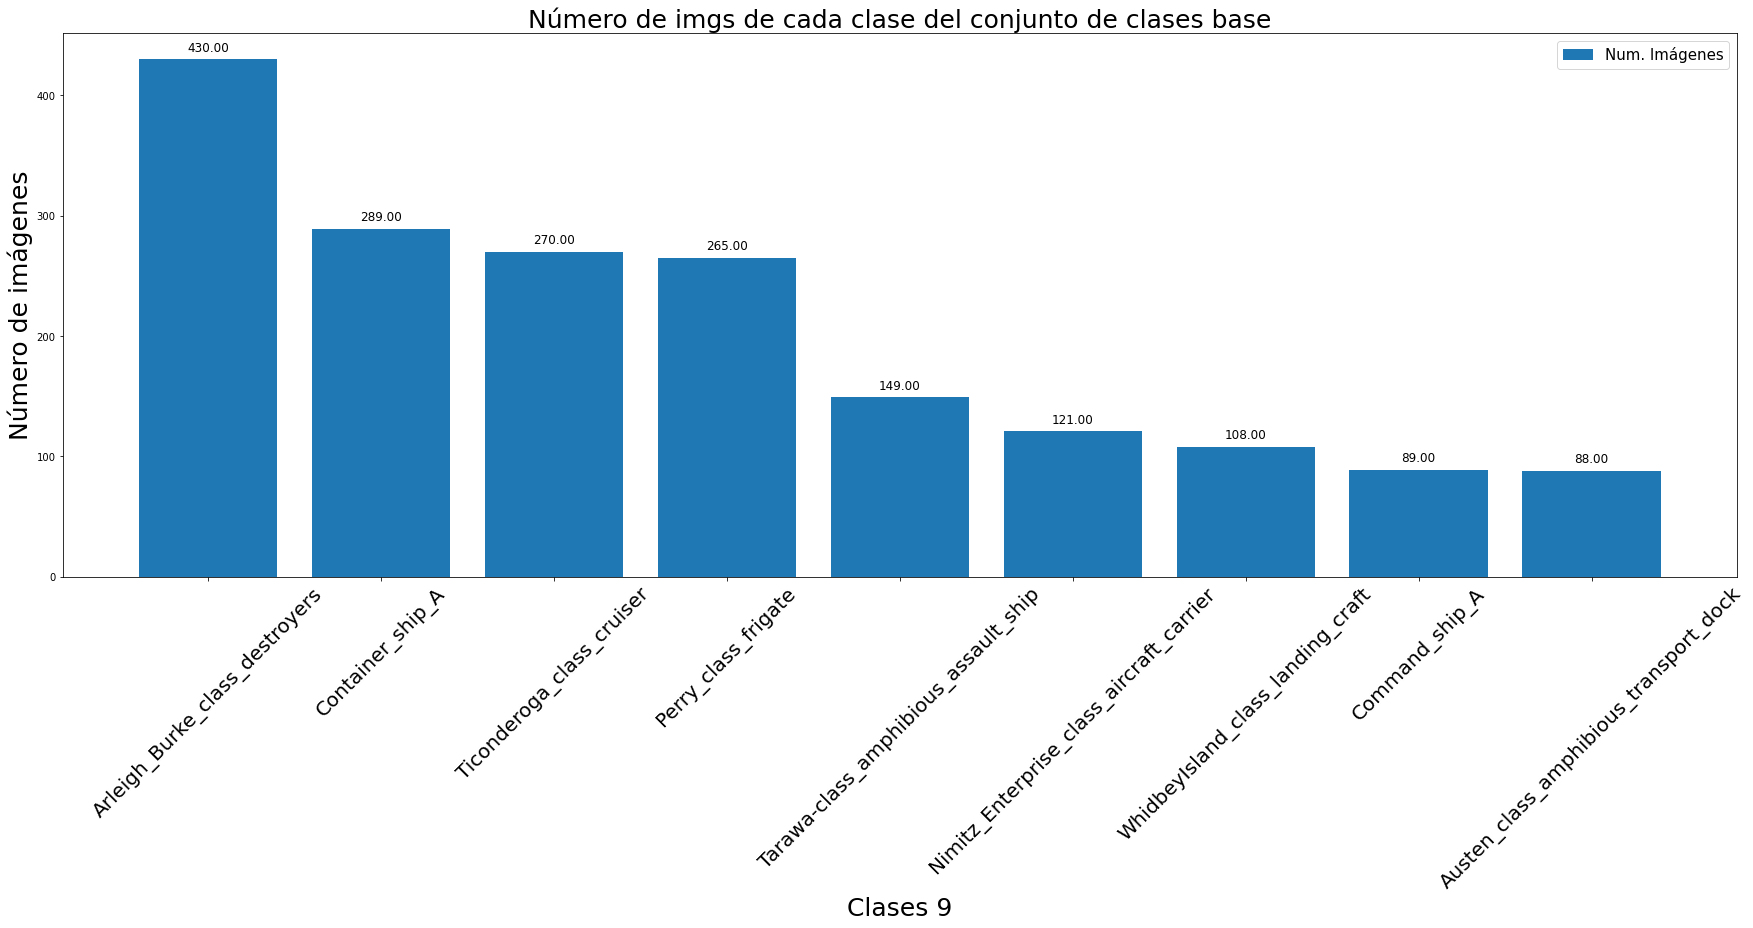

In [10]:
# Representamos el numero de imgs de cada clase
fig, ax = plt.subplots(figsize=(30, 10))
X_axis = np.arange(len(show_classes))
rects1 = ax.bar(X_axis, sorted_num_imgs, align='center', label='Num. Imágenes')

ax.set_xticks(np.arange(len(sorted_classes)))
ax.set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax)

ax.set_xlabel("Clases {}".format(len(show_classes)), fontsize=25)
ax.set_ylabel("Número de imágenes", fontsize=25)
ax.set_title("Número de imgs de cada clase del conjunto de clases base", fontsize=25)
ax.legend(fontsize=15)
plt.show()

De este total de imágenes se divide en 70% - 30%, el 70 para realizar el Fine Tuning del modelo Densenet-121 y el 30 para poder utilizarlo en las pruebas de Few-Shot Learning

Ahora se llevará a cabo la división dentro de los conjuntos de Fine Tuning y FSL para realizar los entrenamientos y test de los diferentes modelos. 

* En el caso del 70% para Fine Tuning se dividirá a su vez en **70% 15% 15%** para los conjuntos de **train, validation y test** necesarios para entrenar la CNN.
* En el caso del 30% para Few Shot Learning se dividirá en **5 imgs** para **S** y el **resto** para **Q**. Estas imágenes de train serán las imágenes de referencia utilizadas para realizar las pruebas con 1 img de referencia y con 5 imgs de referencia, simularán los pocos datos de los que se dispondría para construir el clasificador.

In [11]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 25))
X_axis = np.arange(len(show_classes))

# Representamos los datos de las clases base
rects1 = ax[0].bar(X_axis, sorted_num_imgs_ft, align='center', label='[A] 70% Fine Tuning')
rects2 = ax[0].bar(X_axis, sorted_num_imgs_fsl, align='center', label='[S y Q] 30% Few-Shot Learning')

ax[0].set_xticks(np.arange(len(sorted_classes)))
#ax[0].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[0])

#ax[0].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[0].set_ylabel("Número de imágenes", fontsize=25)
ax[0].set_title("Número de imgs de cada clase del conjunto de clases base", fontsize=25)
ax[0].legend(fontsize=15)

# Representamos las del conjuntos de datos para Fine Tuning
rects1 = ax[1].bar(X_axis - 0.3, sorted_num_imgs_ft_train, width=0.3, align='center', label='FT train')
rects2 = ax[1].bar(X_axis, sorted_num_imgs_ft_val, width=0.3, align='center', label='FT val')
rects3 = ax[1].bar(X_axis + 0.3, sorted_num_imgs_ft_test, width=0.3, align='center', label='FT test')

ax[1].set_xticks(np.arange(len(sorted_classes)))
#ax[1].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[1])

#ax[1].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[1].set_ylabel("Número de imágenes", fontsize=25)
ax[1].set_title("Número de imgs en conjunto para el FT", fontsize=25)
ax[1].legend(fontsize=15)


# Representamos las del conjunto de datos para FSL
rects1 = ax[2].bar(X_axis - 0.35, sorted_num_imgs_fsl_train, width=0.35, align='center', label='FSL S')
rects2 = ax[2].bar(X_axis, sorted_num_imgs_fsl_test, width=0.35, align='center', label='FSL Q')

ax[2].set_xticks(np.arange(len(sorted_classes)))
ax[2].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[2])

ax[2].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[2].set_ylabel("Número de imágenes", fontsize=25)
ax[2].set_title("Número de imgs en conjunto para el FSL", fontsize=25)
ax[2].legend(fontsize=15)

#plt.show()

# Guardamos la img en un fichero 
# fig1 = plt.gcf()
# plt.show()
# plt.draw()
# fig1.savefig('eda_clases_base.png', dpi=100, bbox_inches="tight")

# Imágenes nuevas

Conjunto de imágenes nuevas elegidas para realizar la prueba

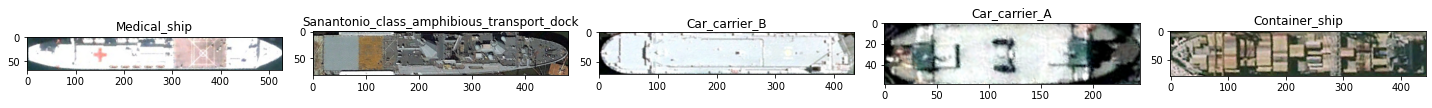

In [12]:
# Carga y ejemplo de las imágenes nuevas de buques del dataset HRSC2016, pertenecientes a clases no utilizadas para
# el FT del modelo.
numCols = 5
numRows = int(math.ceil(len(novel_classes)/numCols))
plot_samples(numRows, numCols, novel_classes, os.path.join(novel_imgs_path, "FSL", "train"), (20,15))

### Análisis Exploratorio de los Datos (EDA) del conjunto novel de imágenes

Se desglosarán en gráficas el número de datos para los modelos de FSL de cada clase del conjunto novel de imágenes

In [19]:
fsl_train_path = os.path.join(novel_imgs_path, "FSL", "train")
fsl_test_path = os.path.join(novel_imgs_path, "FSL", "test")

show_classes = []

num_imgs_fsl_train = []
num_imgs_fsl_test = []
num_imgs_cnn_test = []
num_imgs_cnn_val = []

num_imgs = []
for _class in os.listdir(fsl_train_path):
    # solo consideramos las clases nuevas incuidas para estudio
    if _class in novel_classes:
        show_classes.append(_class)
        _num_imgs = 0
        # num imgs de train
        _num_imgs += len(os.listdir(os.path.join(fsl_train_path, _class)))
        # num imgs de test
        _num_imgs += len(os.listdir(os.path.join(fsl_test_path, _class)))
        
        # el conjunto de ambas hacen el total de las imgs por clase
        num_imgs.append(_num_imgs)
        num_imgs_fsl_train.append(len(os.listdir(os.path.join(fsl_train_path, _class))))
        num_imgs_fsl_test.append(len(os.listdir(os.path.join(fsl_test_path, _class))))
        
        num_test_cnn = int(len(os.listdir(os.path.join(fsl_test_path, _class)))/2)
        num_val_cnn = len(os.listdir(os.path.join(fsl_test_path, _class))) - num_test_cnn
        num_imgs_cnn_test.append(num_test_cnn)
        num_imgs_cnn_val.append(num_val_cnn)
        
# Ordenamos de mayor a menor
sorted_classes = [x for _,x in sorted(zip(num_imgs, show_classes), reverse=True)]
sorted_num_imgs = sorted(num_imgs, reverse=True)

sorted_num_imgs_fsl_train = sorted(num_imgs_fsl_train, reverse=True)
sorted_num_imgs_fsl_test = sorted(num_imgs_fsl_test, reverse=True)

sorted_num_imgs_cnn_test = sorted(num_imgs_cnn_test, reverse=True)
sorted_num_imgs_cnn_val = sorted(num_imgs_cnn_val, reverse=True)

In [21]:
#figure, ax = plt.subplots(figsize=(15, 7))
figure, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 25))
X_axis = np.arange(len(show_classes))

# Representamos las del conjunto de datos para CNN
rects1 = ax[0].bar(X_axis - 0.3, sorted_num_imgs_fsl_train, width=0.3, align='center', label='CNN train')
rects2 = ax[0].bar(X_axis, sorted_num_imgs_cnn_test, width=0.3, align='center', label='CNN test')
rects1 = ax[0].bar(X_axis + 0.3, sorted_num_imgs_cnn_val, width=0.3, align='center', label='CNN validation')

ax[0].set_xticks(np.arange(len(sorted_classes)))
#ax[0].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[0])

#ax[0].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[0].set_ylabel("Número de imágenes", fontsize=25)
ax[0].set_title("Número de imgs en conjunto para CNN", fontsize=25)
ax[0].legend(fontsize=15)


# Representamos las del conjunto de datos para FSL
rects1 = ax[1].bar(X_axis - 0.5, sorted_num_imgs_fsl_train, width=0.5, align='center', label='FSL S')
rects2 = ax[1].bar(X_axis, sorted_num_imgs_fsl_test, width=0.5, align='center', label='FSL Q')

ax[1].set_xticks(np.arange(len(sorted_classes)))
ax[1].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[1])

ax[1].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[1].set_ylabel("Número de imágenes", fontsize=25)
ax[1].set_title("Número de imgs en conjunto para el FSL", fontsize=25)
ax[1].legend(fontsize=15)

plt.show()

# Guardamos la img en un fichero 
# fig1 = plt.gcf()
# plt.show()
# plt.draw()
# fig1.savefig('eda_clases_novel.png', dpi=100, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

# Imágenes extra

Conjunto de imágenes extra elegidas para realizar la prueba

In [8]:
# Carga y ejemplo de las imágenes extra de buques desconocidos de los que
# dispondremos de pocas imágenes de ejemplos.
numCols = 2
numRows = int(math.ceil(len(extra_classes)/numCols))
plot_samples(numRows, numCols, extra_classes, os.path.join(extra_imgs_path, "FSL", "train"), (7,3))

### Análisis Exploratorio de los Datos (EDA) del conjunto extra de imágenes

Se desglosarán en gráficas el número de datos para los modelos de FSL de cada clase del conjunto extra de imágenes

In [25]:
fsl_train_path = os.path.join(extra_imgs_path, "FSL", "train")
fsl_test_path = os.path.join(extra_imgs_path, "FSL", "test")

show_classes = []

num_imgs_fsl_train = []
num_imgs_fsl_test = []
num_imgs_cnn_test = []
num_imgs_cnn_val = []

num_imgs = []
for _class in os.listdir(fsl_train_path):
    # solo consideramos las clases nuevas incuidas para estudio
    if _class in extra_classes:
        show_classes.append(_class)
        _num_imgs = 0
        # num imgs de train
        _num_imgs += len(os.listdir(os.path.join(fsl_train_path, _class)))
        # num imgs de test
        _num_imgs += len(os.listdir(os.path.join(fsl_test_path, _class)))
        
        # el conjunto de ambas hacen el total de las imgs por clase
        num_imgs.append(_num_imgs)
        num_imgs_fsl_train.append(len(os.listdir(os.path.join(fsl_train_path, _class))))
        num_imgs_fsl_test.append(len(os.listdir(os.path.join(fsl_test_path, _class))))
        
        num_test_cnn = int(len(os.listdir(os.path.join(fsl_test_path, _class)))/2)
        num_val_cnn = len(os.listdir(os.path.join(fsl_test_path, _class))) - num_test_cnn
        num_imgs_cnn_test.append(num_test_cnn)
        num_imgs_cnn_val.append(num_val_cnn)
        
# Ordenamos de mayor a menor
sorted_classes = [x for _,x in sorted(zip(num_imgs, show_classes), reverse=True)]
sorted_num_imgs = sorted(num_imgs, reverse=True)

sorted_num_imgs_fsl_train = sorted(num_imgs_fsl_train, reverse=True)
sorted_num_imgs_fsl_test = sorted(num_imgs_fsl_test, reverse=True)

sorted_num_imgs_cnn_test = sorted(num_imgs_cnn_test, reverse=True)
sorted_num_imgs_cnn_val = sorted(num_imgs_cnn_val, reverse=True)

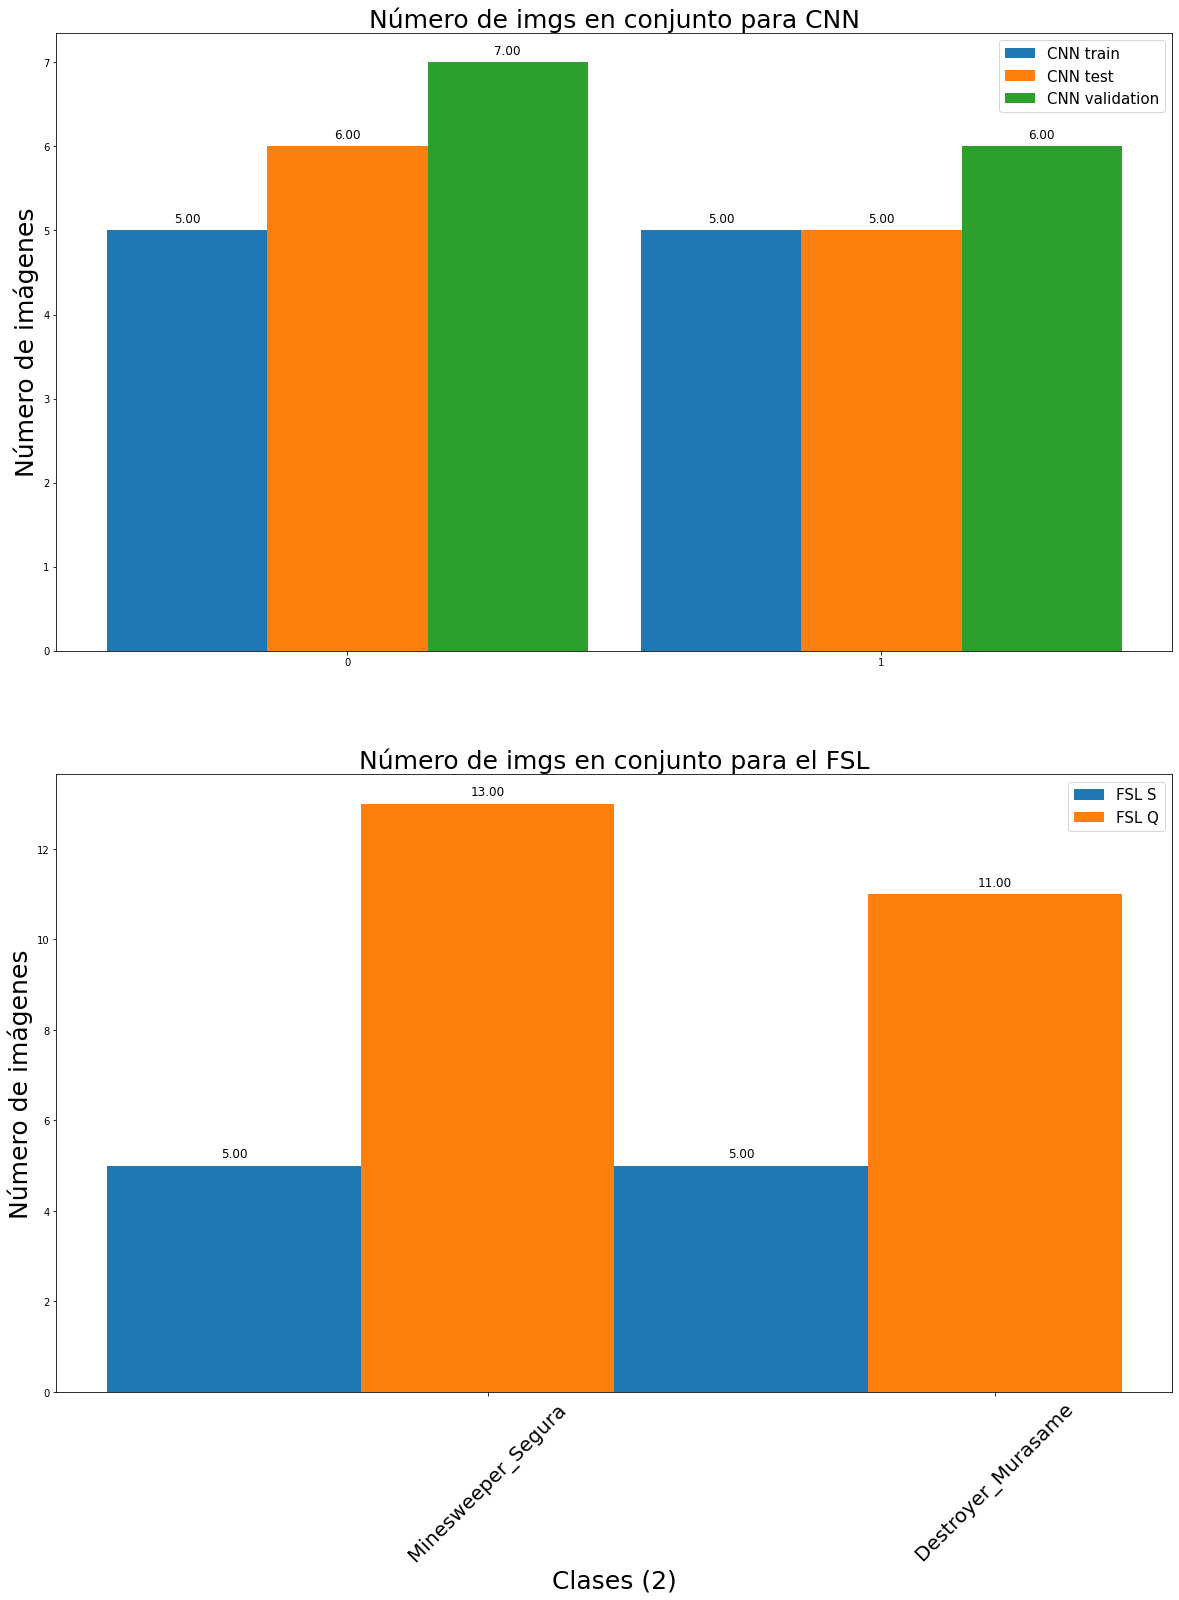

<Figure size 432x288 with 0 Axes>

In [27]:
figure, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 25))
X_axis = np.arange(len(show_classes))

# Representamos las del conjunto de datos para CNN
rects1 = ax[0].bar(X_axis - 0.3, sorted_num_imgs_fsl_train, width=0.3, align='center', label='CNN train')
rects2 = ax[0].bar(X_axis, sorted_num_imgs_cnn_test, width=0.3, align='center', label='CNN test')
rects1 = ax[0].bar(X_axis + 0.3, sorted_num_imgs_cnn_val, width=0.3, align='center', label='CNN validation')

ax[0].set_xticks(np.arange(len(sorted_classes)))
#ax[0].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[0])

#ax[0].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[0].set_ylabel("Número de imágenes", fontsize=25)
ax[0].set_title("Número de imgs en conjunto para CNN", fontsize=25)
ax[0].legend(fontsize=15)


# Representamos las del conjunto de datos para FSL
rects1 = ax[1].bar(X_axis - 0.5, sorted_num_imgs_fsl_train, width=0.5, align='center', label='FSL S')
rects2 = ax[1].bar(X_axis, sorted_num_imgs_fsl_test, width=0.5, align='center', label='FSL Q')

ax[1].set_xticks(np.arange(len(sorted_classes)))
ax[1].set_xticklabels(sorted_classes, rotation=45, fontsize=20)

add_value_labels(ax[1])

ax[1].set_xlabel("Clases ({})".format(len(show_classes)), fontsize=25)
ax[1].set_ylabel("Número de imágenes", fontsize=25)
ax[1].set_title("Número de imgs en conjunto para el FSL", fontsize=25)
ax[1].legend(fontsize=15)

plt.show()

# Guardamos la img en un fichero 
# fig1 = plt.gcf()
# plt.show()
# plt.draw()
# fig1.savefig('eda_clases_extra.png', dpi=100, bbox_inches="tight")

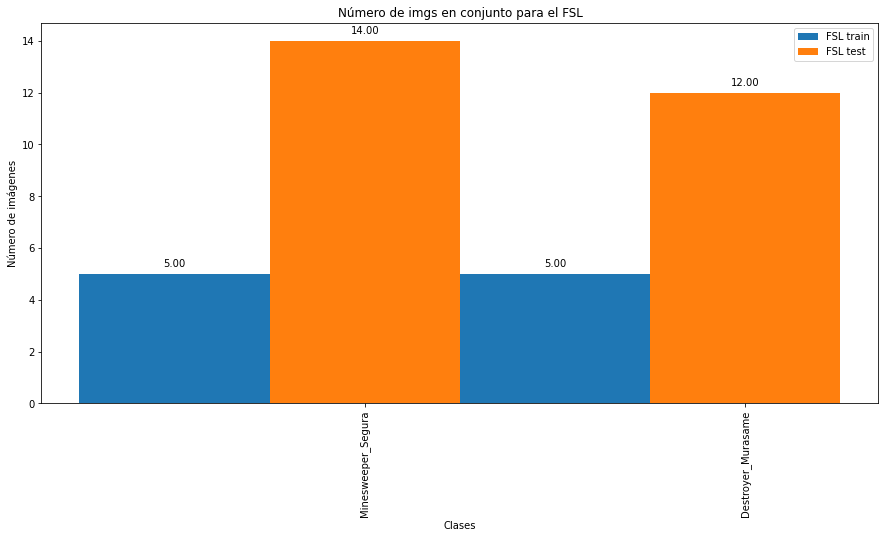

In [14]:
figure, ax = plt.subplots(figsize=(15, 7))
X_axis = np.arange(len(show_classes))


# Representamos las del conjunto de datos para FSL
rects1 = ax.bar(X_axis - 0.5, sorted_num_imgs_fsl_train, width=0.5, align='center', label='FSL S')
rects2 = ax.bar(X_axis, sorted_num_imgs_fsl_test, width=0.5, align='center', label='FSL Q')

ax.set_xticks(np.arange(len(sorted_classes)))
ax.set_xticklabels(sorted_classes, rotation='vertical')

add_value_labels(ax)

ax.set_xlabel("Clases")
ax.set_ylabel("Número de imágenes")
ax.set_title("Número de imgs en conjunto para el FSL")
ax.legend()

plt.show()

# Entrenamiento de los modelos

Antes de lanzar las pruebas se ha de realizar el Transfer Learning del modelo base EfficientNet para que con el Fine Tuning sea capaz de extraer características de los buques.

## Fine Tuning del modelo EfficientNet-B5

Se ofrecen a continuación los resultados de Fine Tuning del modelo de EfficientNet-B5

### Loss & accuracy

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


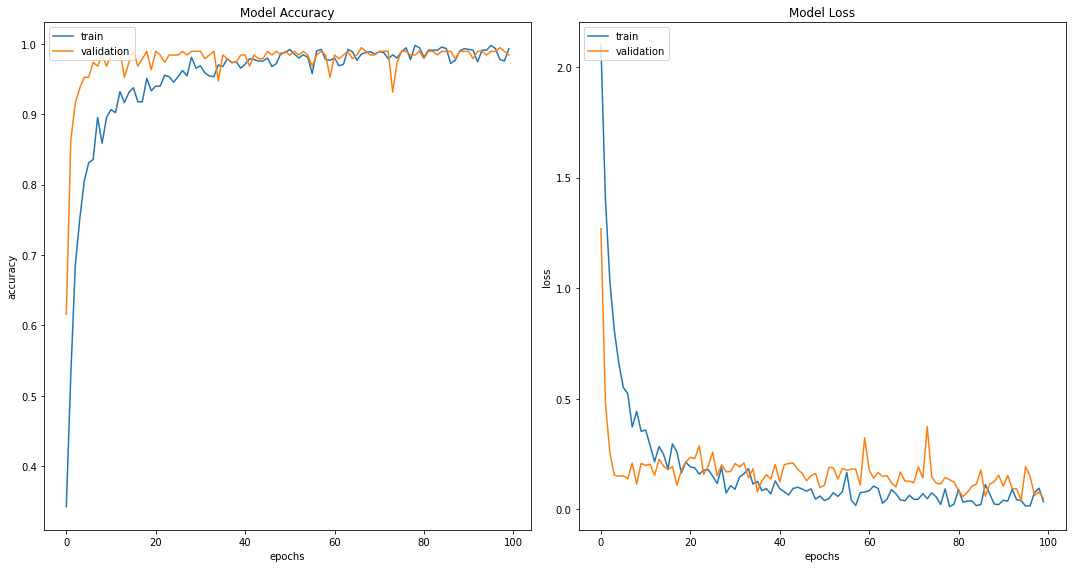

In [5]:
VERSION='v4'
# Cargamos los valores de loss y accuracy de train
train_loss = []
train_accuracy = []
train_logs_path = glob('/var/seda-test-models/CU-02/logs/'+VERSION+'/*/train/*.v2')[0]
for e in tf.compat.v1.train.summary_iterator(train_logs_path):
    for v in e.summary.value:
        if v.tag == 'epoch_loss':
            train_loss.append(v.simple_value)
        if v.tag == 'epoch_accuracy':
            train_accuracy.append(v.simple_value)
            
# Cargamos los valores de loss y accuracy de validation
val_loss = []
val_accuracy = []
val_logs_path = glob('/var/seda-test-models/CU-02/logs/'+VERSION+'/*/validation/*.v2')[0]
for e in tf.compat.v1.train.summary_iterator(val_logs_path):
    for v in e.summary.value:
        if v.tag == 'epoch_loss':
            val_loss.append(v.simple_value)
        if v.tag == 'epoch_accuracy':
            val_accuracy.append(v.simple_value)
            
# Mostramos las gráficas del entrenamiento del modelo base
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
# summarize history for accuracy
axes[0].plot(train_accuracy)
axes[0].plot(val_accuracy)
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axes[1].plot(train_loss)
axes[1].plot(val_loss)
axes[1].set_title('Model Loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'validation'], loc='upper left')

figure.tight_layout()
plt.show()

### Matriz de confusión

In [7]:
# Cargamos el modelo preentrenado con FT
config_ft = Config(os.path.join(base_model, 'config', 'seda_boat_classif_CU-02_FT_'+VERSION+'.json'))
model_ft = factory.Model(config_ft)
model_ft.load(config_ft.callbacks['checkpoint_dir']) # o poner aquí directamente el path "/var/seda-test-models/CU-02/weights/BoatClassif_CU-02_FT/DenseNet121_FT_Boats_"+VERSION
# Cargamos los datos
data = factory.DataLoader(config_ft)

experiments/checkpoints/BoatClassif_CU-02_FT/EfficientNet_FT_Boats_v4
Loading model checkpoint at experiments/checkpoints/BoatClassif_CU-02_FT/EfficientNet_FT_Boats_v4/EfficientNet_FT_Boats_v4-hrsc_boats_classif_0.9947-67_20210903-142557.h5 ...
Model loaded
Classes: ['Arleigh_Burke_class_destroyers' 'Austen_class_amphibious_transport_dock'
 'Command_ship_A' 'Container_ship_A'
 'Nimitz_Enterprise_class_aircraft_carrier' 'Perry_class_frigate'
 'Tarawa-class_amphibious_assault_ship' 'Ticonderoga_class_cruiser'
 'WhidbeyIsland_class_landing_craft']
Train split: 900 images
Validation split: 190 images
Test split: 198 images


Los datos NO necesitan ser normalizados
Arleigh_Burke_class_destroyers 
	Recall: 0.94 - Precision: 0.96 - F-1: 0.95 - Accuracy: 0.97

Austen_class_amphibious_transport_dock 
	Recall: 1.0 - Precision: 0.9 - F-1: 0.95 - Accuracy: 0.99

Command_ship_A 
	Recall: 1.0 - Precision: 1.0 - F-1: 1.0 - Accuracy: 1.0

Container_ship_A 
	Recall: 1.0 - Precision: 1.0 - F-1: 1.0 - Accuracy: 1.0

Nimitz_Enterprise_class_aircraft_carrier 
	Recall: 1.0 - Precision: 1.0 - F-1: 1.0 - Accuracy: 1.0

Perry_class_frigate 
	Recall: 0.94 - Precision: 1.0 - F-1: 0.97 - Accuracy: 0.99

Tarawa-class_amphibious_assault_ship 
	Recall: 1.0 - Precision: 1.0 - F-1: 1.0 - Accuracy: 1.0

Ticonderoga_class_cruiser 
	Recall: 0.97 - Precision: 0.89 - F-1: 0.93 - Accuracy: 0.97

WhidbeyIsland_class_landing_craft 
	Recall: 0.92 - Precision: 1.0 - F-1: 0.96 - Accuracy: 0.99

TOTAL: 
	Recall: 0.97 - Precision: 0.97 - F-1: 0.97 - Accuracy: 0.99



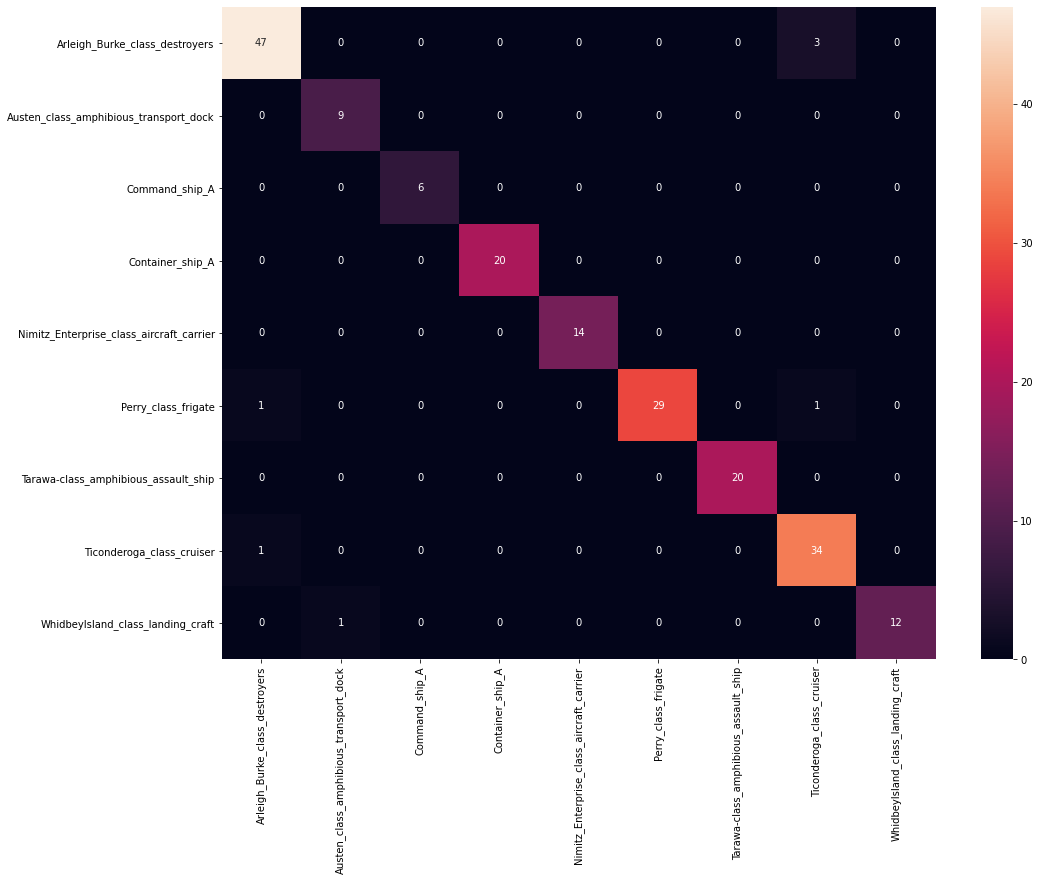

In [8]:
# Generamos la matriz de confusión
# Recorremos el conjunto de test y anotamos las predicciones y los Ground Truth
y_true = []
y_pred = []

if config_ft.trainer['normalized_img']:
    print("Los datos necesitan ser normalizados")
    #for img, label in data.test.take(1):
    #    print(img.dtype)
    #    print(img)
    data.test = data.test.map(normalize)
    data.test = data.test.map(_fixup_shape)
    #for img, label in data.test.take(1):
    #    print(img.dtype)
    #    print(img)
else:
    print("Los datos NO necesitan ser normalizados")
    
for i, (im, label) in enumerate(data.test):
    # pred
    pred = model_ft.model.predict(tf.expand_dims(im, axis = 0))
    y_pred.append(np.argmax(pred[0]))
    # gt
    class_index = np.argmax(label.numpy())
    y_true.append(class_index)

                  
y_true = np.array(y_true)
y_pred = np.array(y_pred)

metrics = get_metrics(y_true, y_pred, data.class_names, None)

# Imprimimos las metricas por clase y en total
total_r, total_p, total_f1, total_acc = 0, 0, 0, 0
for _class in metrics: # metrics es un dict. que tiene la media de recall, precision, f-1 y acc de cada clase
    metric = metrics[_class]
    print("{} \n\tRecall: {} - Precision: {} - F-1: {} - Accuracy: {}\n".format(_class, round(metric[0],2), round(metric[1],2), round(metric[2],2), round(metric[3],2)))
    total_r += metric[0]
    total_p += metric[1]
    total_f1 += metric[2]
    total_acc += metric[3]
num_results = len(list(metrics.keys()))
print("TOTAL: \n\tRecall: {} - Precision: {} - F-1: {} - Accuracy: {}\n".format(round(total_r/num_results,2), round(total_p/num_results,2), 
                                                                                round(total_f1/num_results,2), round(total_acc/num_results,2)))

# Bucles de entrenamiento CNN y FSL para la comparativa

En esta sección se indica el código utilizado para la generación de modelos a comparar así como el testeo de los mismos en 10 pruebas iterativas para cada conjunto de entrenamiento. Estas pruebas componen los documentos CSV sobre los que se calcula la media posteriormente para generar el resumen de resultados y las gráficas comparativas.

Se ha utilizado el código del fichero `src/train_cnn_fsl.py` alojado en el repositorio [Repositorio TFE Manuel Naranjo Martínez](https://bitbucket.org/masteria-fundae/tfm_fsl_vs_cnn/src/master/)

# Resumen de resultados y generación de gráficas

En este apartado se incluirán las celdas para la recopilación de los datos y generación de las gráficas comparativas.

## Recopilación de los datos

Se recorrerán los ficheros CSV donde se han anotado los resultados de las métricas y se realizará la media entre todos ellos para generar un fichero resumen

In [4]:
results_path = "/var/seda-datasets/1.DS_Terceros/1.1.RGB/HRSC2016/HRSC2016/CU-02/results_tfe/reports"
report_resume_path = os.path.join(results_path, 'report_resume.txt')
model_type = ['cnn', 'fsl']
data_types = ['base', 'novel', 'extra']

base_metrics = []
novel_metrics = []
extra_metrics = []

with open(report_resume_path, 'w') as f:
    for model_type_name in os.listdir(results_path):
        model_type_path = os.path.join(results_path, model_type_name)
        if os.path.isdir(model_type_path):
            print("#####################\n        {}\n#####################".format(model_type_name.upper()), file=f)
            for report_csv in os.listdir(model_type_path):
                report_path = os.path.join(model_type_path, report_csv)

                df_report = pd.read_csv(report_path, engine='python')
                mean_trainning_duration =  df_report['trainning_duration'].mean()
                print("{} - Trainning duration: {} s".format(report_csv, round(mean_trainning_duration,2)), file=f)
                for index, test in df_report.iterrows():
                    str_classes = test['classes']
                    str_classes = str_classes.replace("'", "\"")
                    classes = json.loads(str_classes)

                    str_metrics_per_class = test['metrics_per_class']
                    str_metrics_per_class = str_metrics_per_class.replace("'", "\"")
                    str_metrics_per_class = str_metrics_per_class.replace("nan,", "0.0,")

                    metrics_per_class = json.loads(str_metrics_per_class)
                    for k, group_classes in enumerate(classes):
                        for _class in group_classes:
                            if _class in base_classes: #if k == 0: # base 
                                base_metrics.append(np.array(metrics_per_class[_class]))
                            elif _class in novel_classes: #if k == 1: # novel
                                novel_metrics.append(np.array(metrics_per_class[_class]))
                            elif _class in extra_classes: #: # extra
                                extra_metrics.append(np.array(metrics_per_class[_class]))
                        
                metrics_per_data_type = np.array([np.array(base_metrics), np.array(novel_metrics), np.array(extra_metrics)])
                #print(type(metrics_per_data_type))
                #print("metrics shape: {} ".format(metrics_per_data_type.shape))
                #print("metrics_per_type shape: {} ".format(metrics_per_data_type[0].shape))

                for j, data_type in enumerate(data_types):
                    print("\t{} --> recall, prediction, f1, acc".format(data_type), file=f)
                    print("\t\t{}".format(np.mean(metrics_per_data_type[j], axis=0)), file=f)
        

/home/sutton/anaconda3/envs/seda_dl/lib/python3.6/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Generación de gráficas

Se presentará el código para representar los resultados obtenidos de las métricas

/home/sutton/anaconda3/envs/seda_dl/lib/python3.6/site-packages/ipykernel_launcher.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


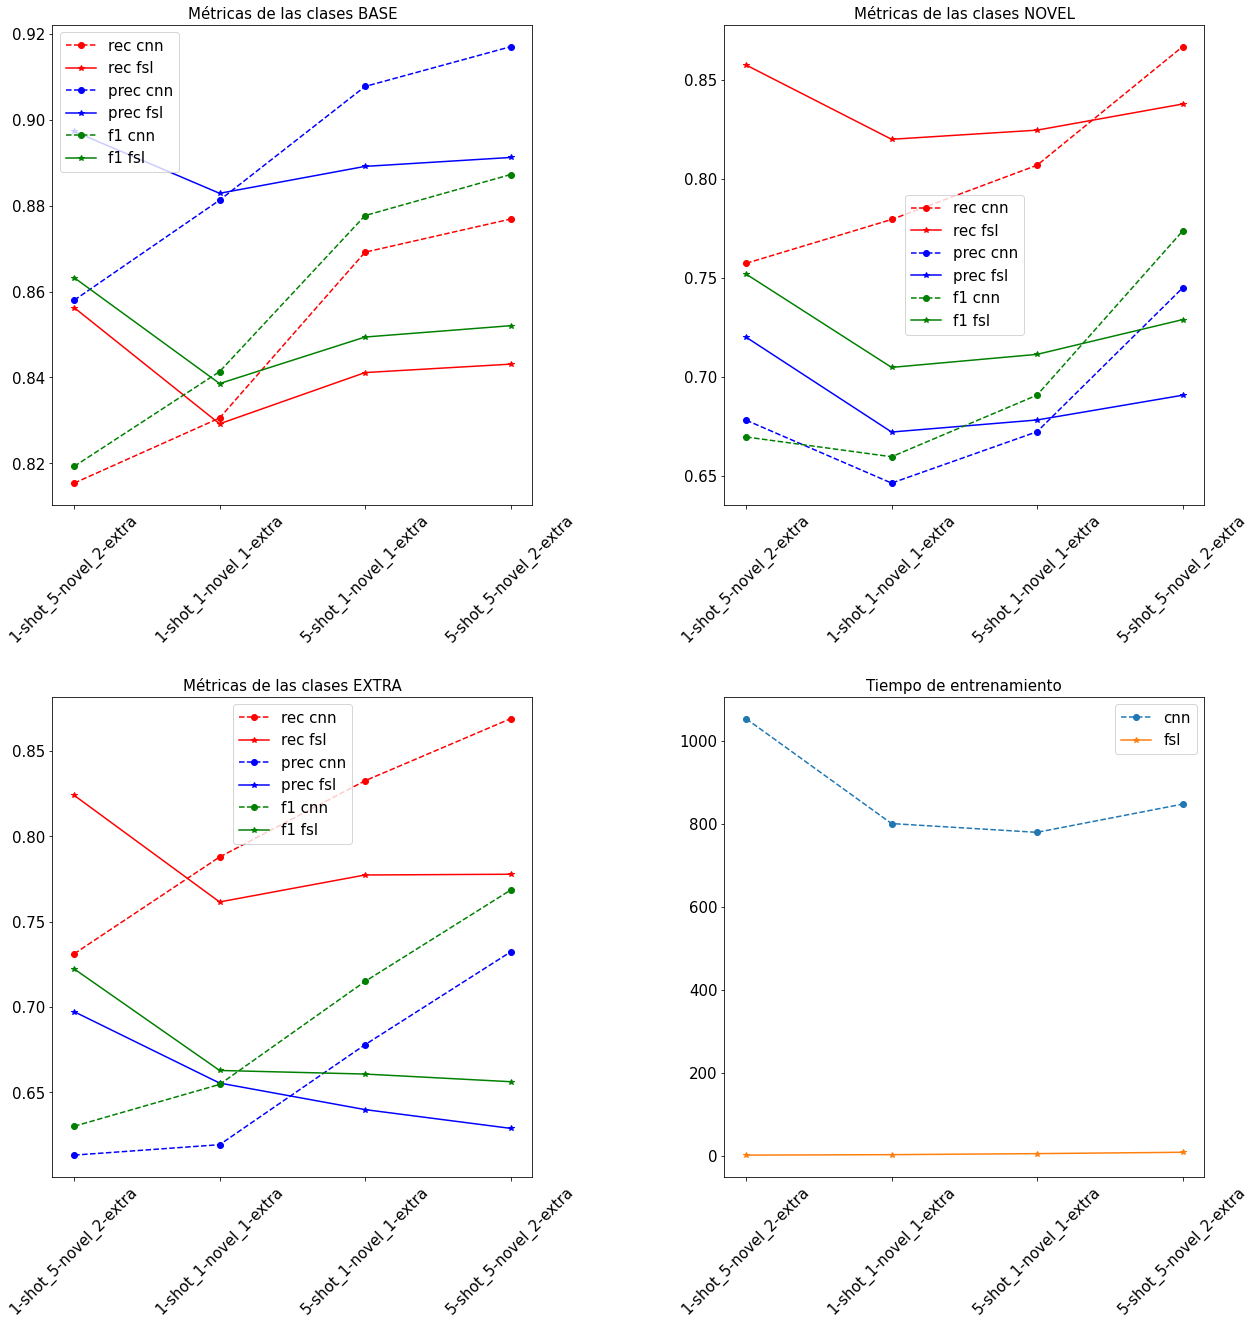

In [5]:
graph_metrics_path = os.path.join(results_path, 'graph_metrics.png')

model_type = ['cnn', 'fsl']
data_types = ['base', 'novel', 'extra']

base_metrics = []
novel_metrics = []
extra_metrics = []

# Arrays de valores a representar
plot_values = {
    "trainning_duration": {
        "cnn" : [],
        "fsl" : []
    },
    "base": {
        "0": {# recall
            "cnn": [],
            "fsl": []
        },
        "1": { # precsion
            "cnn": [],
            "fsl": []
        },
        "2": {# f1
            "cnn": [],
            "fsl": []
        }
    },
    "novel": {
        "0": {
            "cnn": [],
            "fsl": []
        },
        "1": {
            "cnn": [],
            "fsl": []
        },
        "2": {
            "cnn": [],
            "fsl": []
        }
    },
    "extra": {
        "0": {
            "cnn": [],
            "fsl": []
        },
        "1": {
            "cnn": [],
            "fsl": []
        },
        "2": {
            "cnn": [],
            "fsl": []
        }
    }
}

for model_type_name in os.listdir(results_path):
    model_type_path = os.path.join(results_path, model_type_name)
    if os.path.isdir(model_type_path):
        #print("#####################\n        {}\n#####################".format(model_type_name.upper()))
        for report_csv in os.listdir(model_type_path):
            report_path = os.path.join(model_type_path, report_csv)

            df_report = pd.read_csv(report_path, engine='python')
            mean_trainning_duration =  df_report['trainning_duration'].mean()
            plot_values['trainning_duration'][model_type_name].append(mean_trainning_duration)
            #print("{} - Trainning duration: {} s".format(report_csv, round(mean_trainning_duration,2)))
            for index, test in df_report.iterrows():
                str_classes = test['classes']
                str_classes = str_classes.replace("'", "\"")
                classes = json.loads(str_classes)

                str_metrics_per_class = test['metrics_per_class']
                str_metrics_per_class = str_metrics_per_class.replace("'", "\"")
                str_metrics_per_class = str_metrics_per_class.replace("nan,", "0.0,")

                metrics_per_class = json.loads(str_metrics_per_class)
                for k, group_classes in enumerate(classes):
                    for _class in group_classes:
                        if _class in base_classes: #if k == 0: # base 
                            base_metrics.append(np.array(metrics_per_class[_class]))
                        elif _class in novel_classes: #if k == 1: # novel
                            novel_metrics.append(np.array(metrics_per_class[_class]))
                        elif _class in extra_classes: #: # extra
                            extra_metrics.append(np.array(metrics_per_class[_class]))
                    
            metrics_per_data_type = np.array([np.array(base_metrics), np.array(novel_metrics), np.array(extra_metrics)])
            #print(type(metrics_per_data_type))
            #print("metrics shape: {} ".format(metrics_per_data_type.shape))
            #print("metrics_per_type shape: {} ".format(metrics_per_data_type[0].shape))

            for j, data_type in enumerate(data_types):
                #print("\t{} --> recall, prediction, f1, acc".format(data_type))
                #print("\t\t{}".format(np.mean(metrics_per_data_type[j], axis=0)))
                for z, metric in enumerate(np.mean(metrics_per_data_type[j], axis=0)):
                    if z<=2:
                        plot_values[data_type][str(z)][model_type_name].append(metric)

# Figura con 2 filas y 2 columnas de subplots
fig, axs = plt.subplots(2, 2, figsize=(20,20))
x = ["1-shot_5-novel_2-extra", "1-shot_1-novel_1-extra", "5-shot_1-novel_1-extra",  "5-shot_5-novel_2-extra"]

# Representacion de los tiempos de duracion
y_cnn = plot_values['trainning_duration']['cnn']
y_fsl = plot_values['trainning_duration']['fsl']
axs[1, 1].plot(x, y_cnn, label='cnn', linestyle='--', marker='o')#, color='b')
axs[1, 1].plot(x, y_fsl, label='fsl', linestyle='-', marker='*')#, color='b')
axs[1, 1].set_title('Tiempo de entrenamiento', fontsize=15)
axs[1, 1].legend(loc="best", fontsize=15)
plt.sca(axs[1, 1])
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

# Representacion de 'recall', 'precision' y 'f1' en conunto 'base'
y_recall_cnn = plot_values['base']["0"]['cnn']
y_recall_fsl = plot_values['base']["0"]['fsl']
axs[0, 0].plot(x, y_recall_cnn, label='rec cnn', linestyle='--', marker='o', color='r')
axs[0, 0].plot(x, y_recall_fsl, label='rec fsl', linestyle='-', marker='*', color='r')
y_precision_cnn = plot_values['base']["1"]['cnn']
y_precision_fsl = plot_values['base']["1"]['fsl']
axs[0, 0].plot(x, y_precision_cnn, label='prec cnn', linestyle='--', marker='o', color='b')
axs[0, 0].plot(x, y_precision_fsl, label='prec fsl', linestyle='-', marker='*', color='b')
y_f1_cnn = plot_values['base']["2"]['cnn']
y_f1_fsl = plot_values['base']["2"]['fsl']
axs[0, 0].plot(x, y_f1_cnn, label='f1 cnn', linestyle='--', marker='o', color='g')
axs[0, 0].plot(x, y_f1_fsl, label='f1 fsl', linestyle='-', marker='*', color='g')
axs[0, 0].set_title('Métricas de las clases BASE', fontsize=15)
axs[0, 0].legend(loc="best", fontsize=15)
plt.sca(axs[0, 0])
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

# Representacion de 'recall', 'precision' y 'f1' en conunto 'novel'
y_recall_cnn = plot_values['novel']["0"]['cnn']
y_recall_fsl = plot_values['novel']["0"]['fsl']
axs[0, 1].plot(x, y_recall_cnn, label='rec cnn', linestyle='--', marker='o', color='r')
axs[0, 1].plot(x, y_recall_fsl, label='rec fsl', linestyle='-', marker='*', color='r')
y_precision_cnn = plot_values['novel']["1"]['cnn']
y_precision_fsl = plot_values['novel']["1"]['fsl']
axs[0, 1].plot(x, y_precision_cnn, label='prec cnn', linestyle='--', marker='o', color='b')
axs[0, 1].plot(x, y_precision_fsl, label='prec fsl', linestyle='-', marker='*', color='b')
y_f1_cnn = plot_values['novel']["2"]['cnn']
y_f1_fsl = plot_values['novel']["2"]['fsl']
axs[0, 1].plot(x, y_f1_cnn, label='f1 cnn', linestyle='--', marker='o', color='g')
axs[0, 1].plot(x, y_f1_fsl, label='f1 fsl', linestyle='-', marker='*', color='g')
axs[0, 1].set_title('Métricas de las clases NOVEL', fontsize=15)
axs[0, 1].legend(loc="best", fontsize=15)
plt.sca(axs[0, 1])
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

# Representacion de 'recall', 'precision' y 'f1' en conunto 'extra'
y_recall_cnn = plot_values['extra']["0"]['cnn']
y_recall_fsl = plot_values['extra']["0"]['fsl']
axs[1, 0].plot(x, y_recall_cnn, label='rec cnn', linestyle='--', marker='o', color='r')
axs[1, 0].plot(x, y_recall_fsl, label='rec fsl', linestyle='-', marker='*', color='r')
y_precision_cnn = plot_values['extra']["1"]['cnn']
y_precision_fsl = plot_values['extra']["1"]['fsl']
axs[1, 0].plot(x, y_precision_cnn, label='prec cnn', linestyle='--', marker='o', color='b')
axs[1, 0].plot(x, y_precision_fsl, label='prec fsl', linestyle='-', marker='*', color='b')
y_f1_cnn = plot_values['extra']["2"]['cnn']
y_f1_fsl = plot_values['extra']["2"]['fsl']
axs[1, 0].plot(x, y_f1_cnn, label='f1 cnn', linestyle='--', marker='o', color='g')
axs[1, 0].plot(x, y_f1_fsl, label='f1 fsl', linestyle='-', marker='*', color='g')
axs[1, 0].set_title('Métricas de las clases EXTRA', fontsize=15)
axs[1, 0].legend(loc="best", fontsize=15)
plt.sca(axs[1, 0])
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)


plt.subplots_adjust(top=0.9, bottom=0.1,
                    left=0.1, right=0.9, 
                    wspace=0.4, hspace=0.4)

##plt.savefig(graph_metrics_path)